# Classifying true and fake strories with logistic regression

Before the advancements in AI, many task requiring understanding of stories were easy for people but notoriously difficult for computers. In order to create an evaluation scheme for language models, cogintive researchers recently collected a database of simple 5-sentence long true and fake stories - the so called <a href="https://arxiv.org/abs/1604.01696">Story Cloze Test</a>. Stories were written by the workers of the <a href="https://www.mturk.com">Amazon Mechanical Turk</a> and each story comes with two alternative (true and fake) endings. The language model is then tested on its ability to identify the correct ending.

Various neural-network based language models reach accuracies on this task around 90% (the <a href="https://arxiv.org/pdf/1905.07504.pdf">BERT</a> or <a href="https://www.aclweb.org/anthology/C18-1149
">MANN</a> model), however just after publishing the dataset, simple machine learning techniques like logistic regression performed even better than neural networks (this was actually only two years ago and given the speed in AI research it is of course no longer true). In this post we describe a simple logistic regression model classifying stories based on hand-designed language features that achieves decent accuracy exceeding 72%. The idea is based on the 
paper by <a href="https://arxiv.org/abs/1703.04330">Mihaylov et. al.</a>

Full implementation is available in the form of simple jupyter notebook on Github.

In [58]:
import warnings
warnings.filterwarnings(action='once')

Let's look first at some examples of sentences in the Story Cloze Test. The data (in total 3472 stories collected, each with two alternative endings) are distributed as equally-sized validation and test set - we train and tune our model on the first set and only look at the latter one when testing the final model. Each row of the files contains the first four sentences of the stories (the story context) and the two alternative endings, with the last column denoting the right ending.

In [7]:
import pandas as pd
df = pd.read_csv('data/data_val.csv')
df.head()

,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding
0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1
1,bff9f820-9605-4875-b9af-fe6f14d04256,Laverne needs to prepare something for her fri...,She decides to bake a batch of brownies.,She chooses a recipe and follows it closely.,Laverne tests one of the brownies to make sure...,The brownies are so delicious Laverne eats two...,Laverne doesn't go to her friend's party.,1
2,e8f628d5-9f97-40ed-8611-fc0e774673c4,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...,2
3,f5226bfe-9f26-4377-b05f-3d9568dbdec1,Gina was worried the cookie dough in the tube ...,She was very happy to find she was wrong.,The cookies from the tube were as good as from...,Gina intended to only eat 2 cookies and save t...,Gina liked the cookies so much she ate them al...,Gina gave the cookies away at her church.,1
4,69ac9b05-b956-402f-9fff-1f926ef9176b,It was my final performance in marching band.,I was playing the snare drum in the band.,We played Thriller and Radar Love.,The performance was flawless.,I was very proud of my performance.,I was very ashamed of my performance.,1


From a quick look it is obvious that deciding on correct ending would be difficult for a model such as logistic regression that has no access to the meaning or sentiment of the sentences. The idea presented in the original paper was then to look at the similarities in the word vector represenations of the story's sentences

The following code transforms the csv file to a list of stories

In [8]:
import nltk
import numpy as np

def read_data(file):
    data = pd.read_csv(file)
    stories = []; labels = []
    for _, row in data.iterrows():
        story = {}
        story['ctx'] = [nltk.word_tokenize(sentence.lower()) for sentence in list(row[1:5])]
        story['ends'] = [nltk.word_tokenize(sentence.lower()) for sentence in list(row[5:7])]
        stories.append(story.copy())
        labels.append(row[7])
    return stories, np.array(labels)

stories, labels = read_data('data/data_val.csv')
print(stories[0],'\n',labels[0])

{'ctx': [['rick', 'grew', 'up', 'in', 'a', 'troubled', 'household', '.'], ['he', 'never', 'found', 'good', 'support', 'in', 'family', ',', 'and', 'turned', 'to', 'gangs', '.'], ['it', 'was', "n't", 'long', 'before', 'rick', 'got', 'shot', 'in', 'a', 'robbery', '.'], ['the', 'incident', 'caused', 'him', 'to', 'turn', 'a', 'new', 'leaf', '.']], 'ends': [['he', 'is', 'happy', 'now', '.'], ['he', 'joined', 'a', 'gang', '.']]} 
 1


To get the word-vector representations, we use the pre-trained GoogleNews vector model that maps each word to a 300-dimensional vector.    

In [43]:
from gensim import models
model = models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

import numpy as np
dim_embedding = 300

#We assign a random vector to all the words not present in the pre-trained model
np.random.seed(10)
UKN = np.random.uniform(low=-0.25, high=0.25, size=dim_embedding)

def w2v(token):
    try:
        return model[token]
    except:
        return UKN

In [38]:
print(f'Embedding of "dog" has shape {w2v(["dog"]).shape}')

Embedding of "dog" has shape (1, 300)


In designing the features from the dataset, we will often use the centroid vector (the average vector of several words) and the cosine distance (corresponding to the angle in 300-dimensional space) between two word vectors.

In [44]:
def centroid(tokens):
        if len(tokens) == 0:
            return np.zeros(shape = [dim_embedding,])
        else:
            return np.mean([w2v(token) for token in tokens], axis = 0)
    
def cosine(vec1, vec2):
    if np.sum(vec1**2)*np.sum(vec2**2) == 0:
        return 0
    else:
        return np.sum(vec1*vec2)/np.sqrt(np.sum(vec1**2)*np.sum(vec2**2))

We are now ready to implement the features

### Centroid vectors

As first feature we take the average centroid vector of sentences of the context (first four sentences of the story) concatenated with the centroid vector of the ending)

In [45]:
def centroid_feature(story):
    ctr_context = np.mean([centroid(sentence) for sentence in story['ctx']], axis = 0)
    return np.concatenate([ctr_context, centroid(story['end'])])

### Average similarities
We take the centroid vector of the ending and compute cosine distances to all vectors corresponding to words in the context. We then return the top 4 similarities as additional features.

In [46]:
def average_sim(story, top_N = [1,2,3,4]):
    ctx_embeddings = [w2v(token) for token in list(set(sum(story['ctx'],[])))]
    words_similarity = sorted([cosine(embedding, centroid(list(set(story['end'])))) for embedding in ctx_embeddings], reverse = True)
    top_similarities = np.asarray([words_similarity[id] for id in top_N])
    return top_similarities

### Maximum similarity
For each word in the context, we choose the most similar word in the ending and take the average of all the similarities.

In [47]:
def max_sim(story):
    words_similarity = []
    for token in list(set(sum(story['ctx'],[]))):
        words_similarity.append(
                    np.max([cosine(w2v(token),w2v(token_end)) for token_end in story['end']])
                    )
    return [np.mean(words_similarity)]

### POS similarity
We classify words in the story based on their POS (= part of speech, which is a different name for word categories such as noun, adjective, verb etc.). For all combinations (POS1, POS2) in the context and ending we compute centroid similarity between all words of type POS1 in the context and all words of type POS2 in the ending

In [48]:
def pos_sim(story, POS = ['VBZ','VBN','VBP','VBG','VBD','VB','RBS','RBR','RB','POS','NN','NNS','JJS','JJR','JJ']):
    POS_context = nltk.pos_tag(sum(story['ctx'],[]))
    POS_end = nltk.pos_tag(story['end'])

    pos_sim = []
    for pos1 in POS:
        for pos2 in POS:
            ctr_context = centroid([token for token, pos in POS_context if pos == pos1])
            ctr_end = centroid([token for token, pos in POS_end if pos == pos2])
            pos_sim.append(cosine(ctr_context, ctr_end))

    return np.array(pos_sim)

Having defined all the features, we now make two stories out of each row in the validation file (with right and wrong ending, respectively) and story feature vectors of all stories in the array of size = data_size x 2 x no_features. Equivalently, we store the labels in the array of size = data_size x 2 where the labels 0, 1 correspond to right and wrong story, respectively.

In [49]:
from utils import update_progress

def get_features(stories):
    
    X = []
    for item in stories:
        story = {}; features = []
        for end in item['ends']:
            story['ctx'] = item['ctx']
            story['end'] = end
            X_story = np.concatenate([feature(story) 
                                       for feature in [centroid_feature, average_sim, max_sim, pos_sim]])
            features.append(X_story)
        X.append(np.stack(features))
    return np.stack(X)

def get_y(labels):
    y = []
    for label in labels:
        y.append(np.array([1,0])) if label == 1 else y.append(np.array([0,1]))
    return np.stack(y)

We are now ready to train the logistic regression classifier! Before feeding the data into the classifier, we need to reshape them such that we get rid of the second dimension representing the two alternative stories. Afterwards, we normalize them such that each feature vector has unit length.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

X = get_features(stories)
y = get_y(labels)
stories_tst, labels_tst = read_data('data/data_test.csv')
Xts = get_features(stories_tst)

lg = LogisticRegression()
lg.fit(normalize(X.reshape([2*X.shape[0],-1]), axis = 1), y.reshape(-1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Once our classifier is trained, we still have to do a little extra work to extract the predicted labels. Each row of the test set again produces two stories with different set of feature vectors. The logistic regression assigns probability of being right to each of the stories, based on the formula

$p(y = 1 | x) = \Bigl[1 + \exp[-(\theta^T x + \theta_0)]\Bigr]^{-1}$

with $x$ the feature vector, $\theta$ the weight vector with the same number of dimensions as $x$ and $\theta_0$ a constant. The ending is then chosen based on the story assigned higher probability score.

In [62]:
from sklearn.metrics import accuracy_score

def predict_labels(clf, X):
    labels = []
    X = normalize(X.reshape([2*X.shape[0],-1]), axis = 1).reshape(X.shape[0],2,-1)
    for x in X:
        prob_true = clf.predict_proba(x)[:,1]
        labels.append(1) if np.argmax(prob_true) == 0 else labels.append(2)
    return np.array(labels)

labels_pred = predict_labels(lg, Xts)
print(f'Accuracy on the test set = {accuracy_score(labels_tst, labels_pred)}')

Accuracy on the test set = 0.7129877071084981


Let's now try to improve a bit the resulting accuracy a bit. We use 5-fold cross-validation to tune the weight penalization parameter of the logistic regression expressed through the parameter $C$. Small $C$ implies small weights $\theta$, $\theta_0$ and slow variation of the probability near the decision surface while large C allows for larger weights and faster variations of the probability.

In [64]:
from sklearn.model_selection import KFold
from copy import deepcopy

kf = KFold(n_splits=5, shuffle=True)

def KFold_cv(clf, X, labels):
    accuracies = []; clfs = []
    for tr_idx, vld_idx in kf.split(X):
        Xtr = X[tr_idx]; ytr = get_y(labels[tr_idx]);
        Xvld = X[vld_idx]; labels_vld = labels[vld_idx];
        clf.fit(normalize(Xtr.reshape([2*Xtr.shape[0],-1]), axis = 1), ytr.reshape(-1))
        labels_pred = predict_labels(clf, Xvld)
        accuracies.append(accuracy_score(labels_vld, labels_pred))
        clfs.append(deepcopy(clf))
    return np.mean(accuracies), clfs

Progress: [####################] 100.0%
Final model c = 3.5938136638046276
Accuracy on the test set = 0.721004810261892


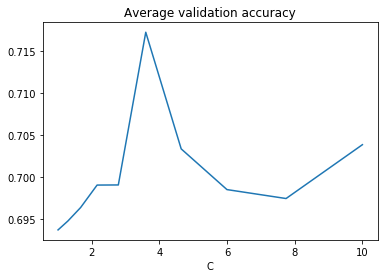

In [72]:
from matplotlib import pyplot as plt

def cv_and_test(X, Xts):
    accs = []; cs = np.logspace(0,1,10)
    print(cs)
    for i, c in enumerate(cs):
        acc, _ = KFold_cv(LogisticRegression(C = c), X, labels)
        accs.append(acc)
        update_progress(i/(len(cs) - 1))

    plt.plot(cs, accs)
    plt.title('Average validation accuracy')
    plt.xlabel('C')

    c_final = cs[np.argmax(accs)]
    print(f'Final model c = {c_final}')
    lg = LogisticRegression(C = c_final)
    lg.fit(normalize(X.reshape([2*X.shape[0],-1]), axis = 1), y.reshape(-1))
    labels_pred = predict_labels(lg, Xts)
    print(f'Accuracy on the test set = {accuracy_score(labels_tst, labels_pred)}')
    
cv_and_test(X, Xts)

Skip thoughts

In [62]:
from skipThoughts import encoder_manager, configuration

encoder_bi = encoder_manager.EncoderManager()
encoder_bi.load_model(configuration.model_config(bidirectional_encoder=True),
                        vocabulary_file='data/skipThoughts/bi/vocab.txt',
                        embedding_matrix_file='data/skipThoughts/bi/embeddings.npy',
                        checkpoint_path='data/skipThoughts/bi/model.ckpt-500008')

encoded = encoder_bi.encode(['Today I cycled to the office'])
print(encoded.shape)

INFO:tensorflow:Reading vocabulary from data/skipThoughts/bi/vocab.txt
INFO:tensorflow:Loaded vocabulary with 930914 words.
INFO:tensorflow:Loading embedding matrix from data/skipThoughts/bi/embeddings.npy
INFO:tensorflow:Loaded embedding matrix with shape (930914, 620)
INFO:tensorflow:Building model.
INFO:tensorflow:Loading model from checkpoint: data/skipThoughts/bi/model.ckpt-500008
INFO:tensorflow:Restoring parameters from data/skipThoughts/bi/model.ckpt-500008
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-500008
(1, 2400)


In [129]:
def st_features(story):
    st_ctx = encoder_bi.encode(story['ctx'])
    st_end = encoder_bi.encode([story['end']]).flatten()
    centroid_ctx = np.mean(st_ctx, axis = 0)
    features = np.concatenate([centroid_ctx, st_end], axis = 0)
    similarities = np.array([cosine(st_vector, st_end) for st_vector in st_ctx])
    return np.concatenate([features, similarities], axis = 0)

def get_st_features(stories):
    X = []
    for i, item in enumerate(stories):
        story = {}; features = []
        for end in item['ends']:
            story['ctx'] = item['ctx']
            story['end'] = end
            X_story = st_features(story)
            features.append(X_story)
        X.append(np.stack(features))
        update_progress(i/(len(stories) - 1))
    return np.stack(X)

In [132]:
X_st = get_st_features(stories)
X_final = np.concatenate([X, X_st], axis = -1)

Progress: [####################] 100.0%


In [136]:
Xts_st = get_st_features(stories_tst)
Xts_final = np.concatenate([Xts, Xts_st], axis = -1)

Progress: [####################] 100.0%


Progress: [####################] 100.0%
c_final = 2.1942803232690182
Accuracy = 0.7439871726349546


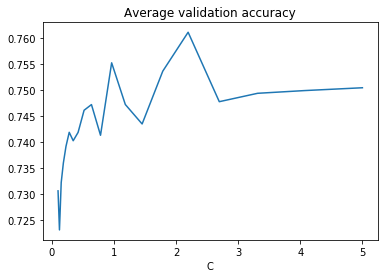

In [144]:
cv_and_test(X_final, Xts_final)